In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
print("Num GPUs} Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs} Available:  1


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization,Dropout, Lambda


################################################################
def multi_unet_model(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    # Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model


In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install tifffile

In [2]:
import numpy as np
import keras
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
import tifffile as tiff
from sklearn.preprocessing import MinMaxScaler

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
train_images_path = "/Users/ajinkya98/Downloads/Colonic_crypt_dataset/train_images"
train_masks_path = "/Users/ajinkya98/Downloads/Colonic_crypt_dataset/train_masks"

In [5]:
train_images = []

for image in sorted(os.listdir(train_images_path)):
    img_path = os.path.join(train_images_path, image)
    print(img_path)
    #img  = Image.open(img_path)
    #print(np.array(img).shape)
    img = cv2.imread(img_path,0)
    print(np.array(img).shape)
    #img = cv2.resize(img, (SIZE_Y, SIZE_X))
    train_images.append(img)
train_images = np.array(train_images)

/Users/ajinkya98/Downloads/Colonic_crypt_dataset/train_images/CL_HandE_1234_B004_bottomleft.tiff
(4536, 4704)
/Users/ajinkya98/Downloads/Colonic_crypt_dataset/train_images/CL_HandE_1234_B004_bottomright.tiff
(4536, 4704)
/Users/ajinkya98/Downloads/Colonic_crypt_dataset/train_images/CL_HandE_1234_B004_topleft.tiff
(4536, 4704)
/Users/ajinkya98/Downloads/Colonic_crypt_dataset/train_images/CL_HandE_1234_B004_topright.tiff
(4536, 4704)
/Users/ajinkya98/Downloads/Colonic_crypt_dataset/train_images/HandE_B005_CL_b_RGB_bottomleft.tiff
(4536, 4704)
/Users/ajinkya98/Downloads/Colonic_crypt_dataset/train_images/HandE_B005_CL_b_RGB_bottomright.tiff
(4536, 4704)
/Users/ajinkya98/Downloads/Colonic_crypt_dataset/train_images/HandE_B005_CL_b_RGB_topleft.tiff
(4536, 4704)


In [6]:
#Capture training masks info as a list
train_masks = []

for image in sorted(os.listdir(train_masks_path)):
    img_path = os.path.join(train_masks_path, image)
    print(img_path)
    img = cv2.imread(img_path,0)  
    print(np.array(img).shape)
    #img = cv2.resize(img, (SIZE_Y, SIZE_X))
#     img[np.where((img[:,:]==5))] = (0)    #temporary fix to remove extra pixel values 3 and 4
#     img[np.where((img[:,:]==6))] = (0) 
#     img[np.where((img[:,:]==7))] = (0)#not to be used in production
    train_masks.append(img)
       
#Convert list to array for machine learning processing        
train_masks = np.array(train_masks)


/Users/ajinkya98/Downloads/Colonic_crypt_dataset/train_masks/CL_HandE_1234_B004_bottomleft.tiff
(4536, 4704)
/Users/ajinkya98/Downloads/Colonic_crypt_dataset/train_masks/CL_HandE_1234_B004_bottomright.tiff
(4536, 4704)
/Users/ajinkya98/Downloads/Colonic_crypt_dataset/train_masks/CL_HandE_1234_B004_topleft.tiff
(4536, 4704)
/Users/ajinkya98/Downloads/Colonic_crypt_dataset/train_masks/CL_HandE_1234_B004_topright.tiff
(4536, 4704)
/Users/ajinkya98/Downloads/Colonic_crypt_dataset/train_masks/HandE_B005_CL_b_RGB_bottomleft.tiff
(4536, 4704)
/Users/ajinkya98/Downloads/Colonic_crypt_dataset/train_masks/HandE_B005_CL_b_RGB_bottomright.tiff
(4536, 4704)
/Users/ajinkya98/Downloads/Colonic_crypt_dataset/train_masks/HandE_B005_CL_b_RGB_topleft.tiff
(4536, 4704)


In [7]:
all_img_patches = []
for img in range(train_images.shape[0]):
    print(img)     #just stop here to see all file names printed
     
    large_image = train_images[img]
    
    patches_img = patchify(large_image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            
            single_patch_img = patches_img[i,j,:,:]
            single_patch_img = (single_patch_img.astype('float32')) / 255.
            #scaler = MinMaxScaler()
            #single_patch_img= scaler.fit_transform(single_patch_img)
            
            all_img_patches.append(single_patch_img)

#This will split the image into small images of shape [3,3]
images = np.array(all_img_patches)

images = np.expand_dims(images, -1)

0
1
2
3
4
5
6


In [8]:
images.shape

(2142, 256, 256, 1)

In [9]:
all_mask_patches = []
for img in range(train_masks.shape[0]):
    #print(img)     #just stop here to see all file names printed
     
    large_mask = train_masks[img]
    
    patches_mask = patchify(large_mask, (256, 256), step=256)  #Step=256 for 256 patches means no overlap
    

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            
            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = single_patch_mask / 255.
            
            all_mask_patches.append(single_patch_mask)

#This will split the image into small images of shape [3,3]
masks = np.array(all_mask_patches)
masks = np.expand_dims(masks, -1)

In [10]:
masks.shape

(2142, 256, 256, 1)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size = 0.20, random_state = 0)

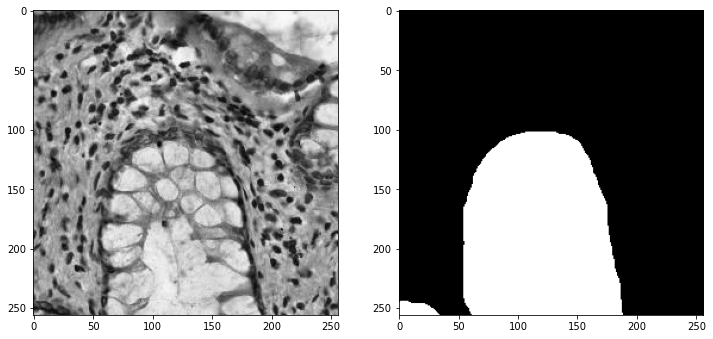

In [12]:
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[64], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[64], (256, 256)), cmap='gray')
plt.show()

In [13]:
n_classes=1
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [14]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization,Dropout, Lambda, Activation, MaxPool2D, Concatenate
from tensorflow.keras.optimizers import Adam

#from tf.keras.models import Model
#from tf.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
# from tf.keras.optimizers import Adam
# from tf.keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [19]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization,Dropout, Lambda


# ################################################################
# def multi_unet_model(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#     # Build the model
#     inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#     s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
#     s = inputs

#     # Contraction path
#     c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
#     c1 = Dropout(0.1)(c1)
#     c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
#     p1 = MaxPooling2D((2, 2))(c1)

#     c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
#     c2 = Dropout(0.1)(c2)
#     c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
#     p2 = MaxPooling2D((2, 2))(c2)

#     c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
#     c3 = Dropout(0.2)(c3)
#     c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
#     p3 = MaxPooling2D((2, 2))(c3)

#     c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
#     c4 = Dropout(0.2)(c4)
#     c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
#     p4 = MaxPooling2D(pool_size=(2, 2))(c4)

#     c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
#     c5 = Dropout(0.3)(c5)
#     c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#     # Expansive path
#     u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
#     u6 = concatenate([u6, c4])
#     c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
#     c6 = Dropout(0.2)(c6)
#     c6 = Conv2D(128, (3, 3), activation='relu' , kernel_initializer='he_normal', padding='same')(c6)

#     u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
#     u7 = concatenate([u7, c3])
#     c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
#     c7 = Dropout(0.2)(c7)
#     c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

#     u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
#     u8 = concatenate([u8, c2])
#     c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
#     c8 = Dropout(0.1)(c8)
#     c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

#     u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
#     u9 = concatenate([u9, c1], axis=3)
#     c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
#     c9 = Dropout(0.1)(c9)
#     c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

#     outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

#     model = Model(inputs=[inputs], outputs=[outputs])

#     # NOTE: Compile the model in the main program to make it easy to test with various loss functions
#     #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#     #model.summary()

#     return model



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate

#Convolutional block to be used in autoencoder and U-Net
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block for autoencoder (no skip connections)
def decoder_block(input, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = conv_block(x, num_filters)
    return x

#Encoder will be the same for Autoencoder and U-net
#We are getting both conv output and maxpool output for convenience.
#we will ignore conv output for Autoencoder. It acts as skip connections for U-Net
def build_encoder(input_image):
    #inputs = Input(input_shape)

    s1, p1 = encoder_block(input_image, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    
    encoded = conv_block(p4, 1024) #Bridge
    
    return encoded

#Decoder for Autoencoder ONLY. 
def build_decoder(encoded):
    d1 = decoder_block(encoded, 512)
    d2 = decoder_block(d1, 256)
    d3 = decoder_block(d2, 128)
    d4 = decoder_block(d3, 64)
    
    decoded = Conv2D(3, 3, padding="same", activation="sigmoid")(d4)
    return decoded

#Use encoder and decoder blocks to build the autoencoder. 
def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    autoencoder = Model(input_img, build_decoder(build_encoder(input_img)))
    return(autoencoder)

# model=build_autoencoder((256, 256, 3))
# print(model.summary())

#Decoder block for unet
#skip features gets input from encoder for concatenation
def decoder_block_for_unet(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block_for_unet(b1, s4, 512)
    d2 = decoder_block_for_unet(d1, s3, 256)
    d3 = decoder_block_for_unet(d2, s2, 128)
    d4 = decoder_block_for_unet(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    print(model.summary())
    return model


In [ ]:
# def get_model():
#     return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)


In [ ]:
# model = get_model()
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

In [ ]:
# # 128 by 128

# #If starting with pre-trained weights. 
# #model.load_weights('???.hdf5')

# history = model.fit(X_train, y_train, batch_size = 32, 
#                     verbose=1, 
#                     epochs=30, 
#                     validation_data=(X_test, y_test),
#                     shuffle=False)
                    


# model.save(r"/content/drive/MyDrive/CV Project/munet.hdf5")
# ############################################################
# #Evaluate the model
# 	# evaluate model
# _, acc = model.evaluate(X_test, y_test)
# print("Accuracy is = ", (acc * 100.0), "%")

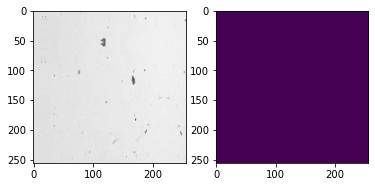

In [20]:
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
#image_data_generator.fit(X_train, augment=True, seed=seed)

batch_size= 4
seed = 24

image_generator = image_data_generator.flow(X_train, seed=seed, batch_size=batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=seed, batch_size=batch_size) #Default batch size 32, if not specified here

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
#mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed, batch_size=batch_size)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed, batch_size=batch_size)  #Default batch size 32, if not specified here

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)


x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()


steps_per_epoch = 3*(len(X_train))//batch_size

In [ ]:
# # With imgeDataGenerator and 256 x 256

# #If starting with pre-trained weights. 
# #model.load_weights('???.hdf5')

# history = model.fit_generator(my_generator, validation_data=validation_datagen, 
#                     steps_per_epoch=steps_per_epoch, 
#                     validation_steps=steps_per_epoch, epochs=30)
                    


# # model.save(r"/content/drive/MyDrive/CV Project/munet.hdf5")
# # ############################################################
# # #Evaluate the model
# # 	# evaluate model
# # _, acc = model.evaluate(X_test, y_test)
# # print("Accuracy is = ", (acc * 100.0), "%")

In [ ]:
# #plot the training and validation accuracy and loss at each epoch
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# acc = history.history['accuracy']
# #acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# #val_acc = history.history['val_accuracy']

# plt.plot(epochs, acc, 'y', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# #IOU
# y_pred=model.predict(X_test)
# y_pred_thresholded = y_pred > 0.5

# intersection = np.logical_and(y_test, y_pred_thresholded)
# union = np.logical_or(y_test, y_pred_thresholded)
# iou_score = np.sum(intersection) / np.sum(union)
# print("IoU socre is: ", iou_score)

# #Predict on a few images
# #model = get_model()
# #model.load_weights('mitochondria_50_plus_100_epochs.hdf5') #Trained for 50 epochs and then additional 100
# #model.load_weights('mitochondria_gpu_tf1.4.hdf5')  #Trained for 50 epochs

In [ ]:
# test_img_number = random.randint(0, len(X_test))
# test_img = X_test[test_img_number]
# ground_truth=y_test[test_img_number]
# test_img_norm=test_img[:,:,0][:,:,None]
# test_img_input=np.expand_dims(test_img_norm, 0)
# prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

# plt.figure(figsize=(16, 8))
# plt.subplot(231)
# plt.title('Testing Image')
# plt.imshow(test_img[:,:,0], cmap='gray')
# plt.subplot(232)
# plt.title('Testing Label')
# plt.imshow(ground_truth[:,:,0], cmap='gray')
# plt.subplot(233)
# plt.title('Prediction on test image')
# plt.imshow(prediction, cmap='gray')

# plt.show()

In [ ]:
# # With imgeDataGenerator and 512 x 512

# #If starting with pre-trained weights. 
# #model.load_weights('???.hdf5')
# with tf.device('/device:GPU:0'):
#     history = model.fit_generator(my_generator, validation_data=validation_datagen, 
#                         steps_per_epoch=steps_per_epoch, 
#                         validation_steps=steps_per_epoch, epochs=30)
                    


# model.save(r"/munet_512.hdf5")
# ############################################################
# # Evaluate the model
# # 	evaluate model
# # _, acc = model.evaluate(X_test, y_test)
# # print("Accuracy is = ", (acc * 100.0), "%")

In [21]:
model = build_unet(input_shape)
model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2022-05-01 01:17:42.433235: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-01 01:17:42.433537: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                           

 rmalization)                   )                                                                 
                                                                                                  
 activation_8 (Activation)      (None, 16, 16, 1024  0           ['batch_normalization_8[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 16, 16, 1024  9438208     ['activation_8[0][0]']           
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 16, 16, 1024  4096       ['conv2d_9[0][0]']               
 rmalization)                   )                                                                 
          

                                                                                                  
 conv2d_16 (Conv2D)             (None, 256, 256, 64  73792       ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 256, 256, 64  256        ['conv2d_16[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_16 (Activation)     (None, 256, 256, 64  0           ['batch_normalization_16[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_17

/Users/ajinkya98/tensorflow/env/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
history = model.fit_generator(my_generator, validation_data=validation_datagen, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_steps=steps_per_epoch, epochs =20)
                    


model.save("unet_256_functional_block.hdf5")
# ############################################################

Epoch 1/20


/var/folders/57/yw764z5n29l1lxbgq38by2780000gn/T/ipykernel_33289/1282334743.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(my_generator, validation_data=validation_datagen,
2022-05-01 01:20:03.130564: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-01 01:20:04.034173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1284/1284 [==============================] - ETA: 0s - loss: 0.2316 - accuracy: 0.9358

2022-05-01 01:30:22.292656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1284/1284 [==============================] - 779s 605ms/step - loss: 0.2316 - accuracy: 0.9358 - val_loss: 0.1952 - val_accuracy: 0.9466
Epoch 2/20
1284/1284 [==============================] - 773s 602ms/step - loss: 0.2263 - accuracy: 0.9352 - val_loss: 0.2215 - val_accuracy: 0.9467
Epoch 3/20
1284/1284 [==============================] - 774s 603ms/step - loss: 0.2199 - accuracy: 0.9351 - val_loss: 0.1920 - val_accuracy: 0.9479
Epoch 4/20
1284/1284 [==============================] - 774s 603ms/step - loss: 0.2116 - accuracy: 0.9362 - val_loss: 0.1945 - val_accuracy: 0.9472
Epoch 5/20
1284/1284 [==============================] - 776s 604ms/step - loss: 0.2050 - accuracy: 0.9350 - val_loss: 0.1613 - val_accuracy: 0.9462
Epoch 6/20
1284/1284 [==============================] - 773s 602ms/step - loss: 0.2025 - accuracy: 0.9351 - val_loss: 0.1683 - val_accuracy: 0.9473
Epoch 7/20
1284/1284 [==============================] - 773s 602ms/step - loss: 0.1947 - accuracy: 0.9354 - val_loss: 0.168

In [ ]:
# from models import build_autoencoder, build_encoder, build_unet

input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
autoencoder_model=build_autoencoder(input_shape)
autoencoder_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(autoencoder_model.summary())

In [ ]:
#Train the autoencoder

history = autoencoder_model.fit(my_generator, validation_data=validation_datagen,
        steps_per_epoch=steps_per_epoch,validation_steps=steps_per_epoch, epochs=30,verbose=1)


autoencoder_model.save('autoencoder_30epochs.h5')


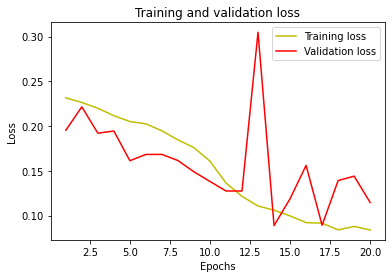

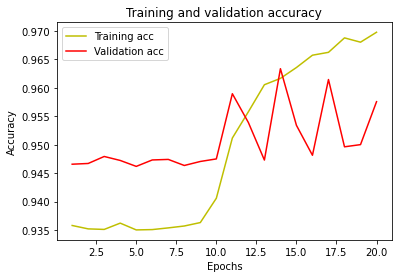

2022-05-01 14:54:37.834416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


IoU socre is:  0.25788808509797984


In [23]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)



In [17]:
#Predict on a few images
model = build_unet(input_shape)
model.load_weights('unet_256_functional_block.hdf5') #Trained for 50 epochs and then additional 100
#model.load_weights('mitochondria_gpu_tf1.4.hdf5')  #Trained for 50 epochs

Metal device set to: Apple M1 Pro


2022-05-02 18:11:29.943475: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-02 18:11:29.943824: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


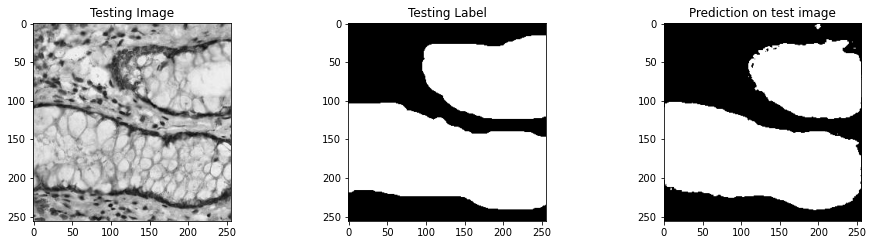

In [393]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [371]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)


IoU socre is:  0.25788808509797984
